In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.metrics import mean_squared_error

In [3]:
train_data = pd.read_csv('insurance_train.csv')
test_data = pd.read_csv('insurance_test.csv')

## 1. Подготовка данных

#### 1. проверить наличие пропусков и выбросов

In [6]:
# Пропуски тренировочных данных
train_data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [7]:
# Пропуски тестовых данных
test_data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [22]:
num_cols = train_data.select_dtypes(include=[np.number])
Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((num_cols < (Q1 - 1.5 * IQR)) | (num_cols > (Q3 + 1.5 * IQR)))

In [20]:
z_scores = np.abs(stats.zscore(train_data.select_dtypes(include=[np.number])))
outliers_z = (z_scores > 3)

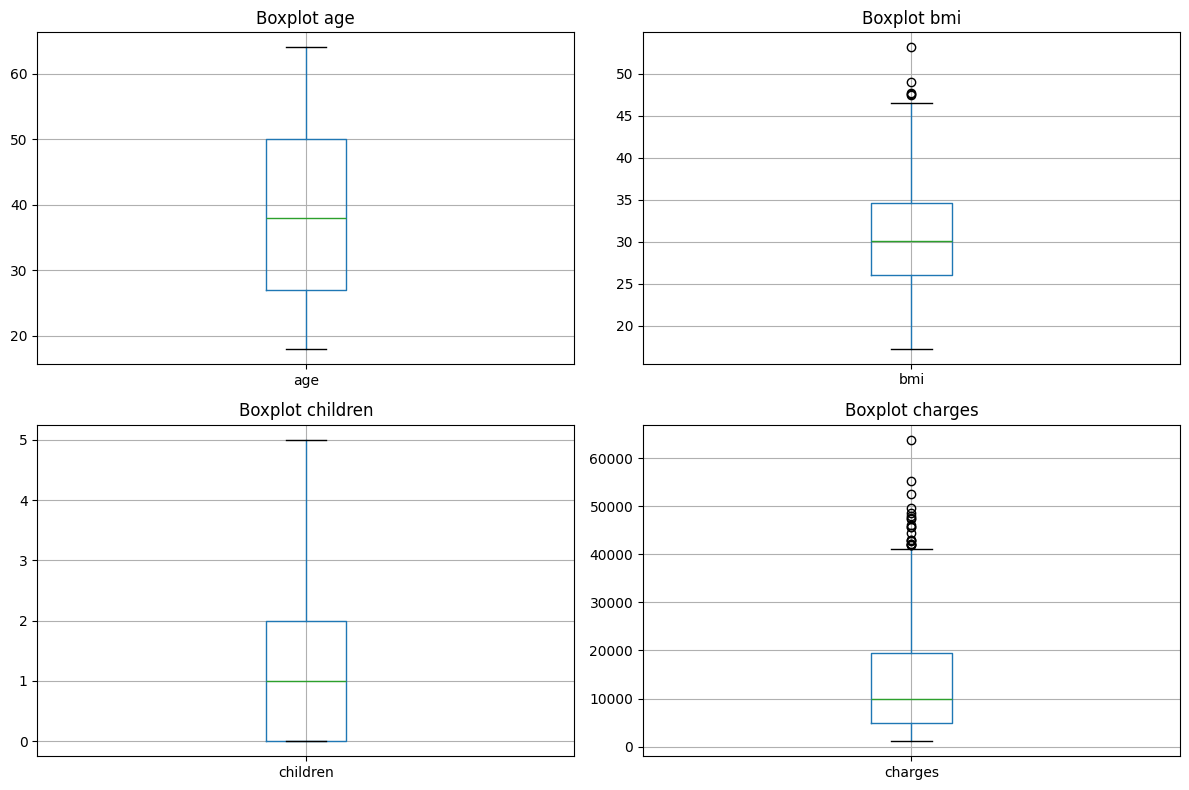

In [26]:
numeric_columns = ['age', 'bmi', 'children', 'charges']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for i, col in enumerate(numeric_columns):
    row, col_idx = i // 2, i % 2
    train_data.boxplot(column=col, ax=axes[row, col_idx])
    axes[row, col_idx].set_title(f'Boxplot {col}')
plt.tight_layout()
plt.show()

#### 2. привести категориальные признаки к числовым

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

categorical_cols = ['sex', 'smoker', 'region']

ct = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', dtype=float, handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

train_processed = ct.fit_transform(train_data)
test_processed  = ct.transform(test_data)

feature_names = ct.get_feature_names_out()
train_processed = pd.DataFrame(train_processed, columns=feature_names, index=train_data.index)
test_processed  = pd.DataFrame(test_processed, columns=feature_names, index=test_data.index)

print("train:", train_processed.shape)
print("test: ", test_processed.shape)
display(train_processed.head())

train: (338, 9)
test:  (1000, 9)


,cat__sex_male,cat__smoker_yes,cat__region_northwest,cat__region_southeast,cat__region_southwest,remainder__age,remainder__bmi,remainder__children,remainder__charges
0,1.0,1.0,0.0,1.0,0.0,26.0,27.060,0.0,17043.34140
1,1.0,1.0,1.0,0.0,0.0,58.0,36.955,2.0,47496.49445
2,0.0,1.0,0.0,1.0,0.0,20.0,24.420,0.0,26125.67477
3,0.0,1.0,0.0,1.0,0.0,51.0,38.060,0.0,44400.40640
4,0.0,0.0,0.0,0.0,1.0,62.0,25.000,0.0,13451.12200


### 3. вычислить парные корреляции признаков

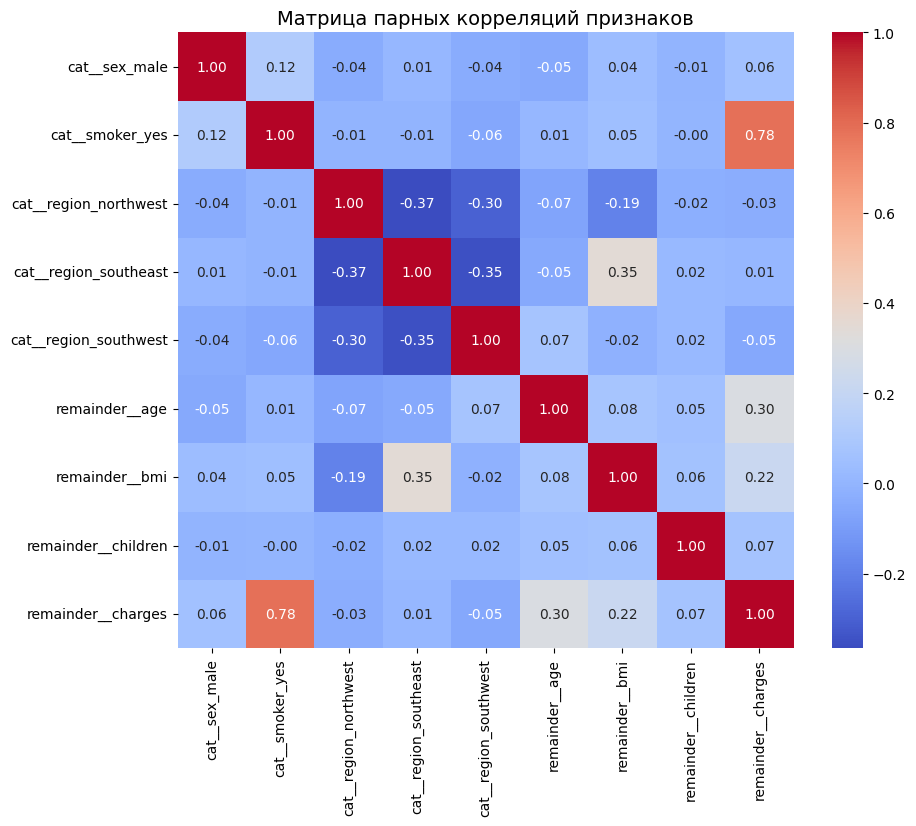

In [28]:
corr_matrix = train_processed.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Матрица парных корреляций признаков", fontsize=14)
plt.show()

## 2. Многомерная линейная регрессия
Построить модель линейной регрессии и подобрать параметры

### 1. аналитически (реализовать самому)

In [33]:
from sklearn.preprocessing import StandardScaler

target_col = "remainder__charges"

y_train = train_processed[target_col].values
y_test = test_processed[target_col].values

X_train = train_processed.drop(columns=[target_col])
X_test = test_processed.drop(columns=[target_col])


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


X_train_b = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test_b = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])


def normal_equation(X, y):
    """
    w = (X^T X)^(-1) X^T y
    """
    return np.linalg.inv(X.T @ X) @ (X.T @ y)

w = normal_equation(X_train_b, y_train)


print("Оптимальные параметры модели (аналитическое решение):\n")

print(f"w0 (intercept): {w[0]:.6f}")

for i, col in enumerate(X_train.columns):
    print(f"{col}: {w[i+1]:.6f}")


Оптимальные параметры модели (аналитическое решение):

w0 (intercept): 14092.861924
cat__sex_male: -327.421295
cat__smoker_yes: 9859.845555
cat__region_northwest: -85.259131
cat__region_southeast: -638.001366
cat__region_southwest: -601.390128
remainder__age: 3495.769492
remainder__bmi: 2210.571768
remainder__children: 581.675135


### 2. численно, с помощью методов градиентного спуска (реализовать самому)

In [34]:
def gradient_descent(X, y, learning_rate, n_iterations):
    m, n = X.shape
    weights = np.zeros(n)
    cost_history = []

    for i in range(n_iterations):
        prediction = X.dot(weights)
        error = prediction - y
        gradient = (1/m) * X.T.dot(error)
        weights -= learning_rate * gradient

        cost = (1/(2*m)) * np.sum(error**2)
        cost_history.append(cost)

    return weights, cost_history


learning_rate = 0.001
n_iterations = 20000

weights_gd, cost_history = gradient_descent(X_train_b, y_train, learning_rate, n_iterations)


print("Веса, найденные градиентным спуском:\n")

print(f"w0 (intercept): {weights_gd[0]:.6f}")

for i, col_name in enumerate(X_train.columns):
    print(f"{col_name}: {weights_gd[i+1]:.6f}")

Веса, найденные градиентным спуском:

w0 (intercept): 14092.861895
cat__sex_male: -327.377608
cat__smoker_yes: 9859.901694
cat__region_northwest: -84.785563
cat__region_southeast: -637.426433
cat__region_southwest: -600.901031
remainder__age: 3495.826637
remainder__bmi: 2210.414216
remainder__children: 581.669591


## 3. Добавление регуляризации
Модифицировать линейную модель путем добавления регуляризационного слагаемого. Найти оптимальные веса:

### 1. аналитически

In [36]:
def analytical_ridge_solution(X, y, lambda_):
    m, n = X.shape
    I = np.eye(n)
    I[0, 0] = 0
    to_invert = X.T @ X + lambda_ * I
    return np.linalg.inv(to_invert) @ X.T @ y


lambda_value = 100

weights_ridge_analytical = analytical_ridge_solution(X_train_b, y_train, lambda_value)


print("Веса (аналитическое Ridge-решение):\n")

print(f"Intercept (w0): {weights_ridge_analytical[0]:.6f}")

for i, col_name in enumerate(X_train.columns):
    print(f"{col_name}: {weights_ridge_analytical[i+1]:.6f}")


Веса (аналитическое Ridge-решение):

Intercept (w0): 14092.861924
cat__sex_male: -59.980940
cat__smoker_yes: 7616.364964
cat__region_northwest: -64.943278
cat__region_southeast: -368.060724
cat__region_southwest: -442.962883
remainder__age: 2758.253096
remainder__bmi: 1765.787141
remainder__children: 495.510974


### 2. численно

In [45]:
def grad_desc_ridge(X, y, learning_rate=0.01, n_iterations=1000, l_lamb=1.0):

    m, n = X.shape
    weights = np.zeros(n)
    cost_history = []

    for i in range(n_iterations):
        prediction = X.dot(weights)
        error = prediction - y

        gradient = (1/m) * X.T.dot(error)

        weights_reg = weights.copy()
        weights_reg[0] = 0

        gradient += (l_lamb/m) * weights_reg

        weights = weights - learning_rate * gradient

        mse_cost = (1/(2*m)) * np.sum(error**2)
        reg_cost = (l_lamb/(2*m)) * np.sum(weights_reg**2)
        total_cost = mse_cost + reg_cost
        cost_history.append(total_cost)

    return weights, cost_history


weights_ridge_gd, cost_history_ridge = grad_desc_ridge(
    X_train_b,
    y_train,
    learning_rate=learning_rate,
    n_iterations=n_iterations,
    l_lamb=l_lamb
)

print("Веса Ridge (градиентный спуск):")

print(f"bias: {weights_ridge_gd[0]:.6f}")

for i, col_name in enumerate(X_train.columns):
    print(f"{col_name}: {weights_ridge_gd[i+1]:.6f}")


Веса Ridge (градиентный спуск):
bias: 14092.861895
cat__sex_male: -59.980882
cat__smoker_yes: 7616.365039
cat__region_northwest: -64.942641
cat__region_southeast: -368.059951
cat__region_southwest: -442.962226
remainder__age: 2758.253173
remainder__bmi: 1765.786929
remainder__children: 495.510967


### 4. Оценка обобщающей способности
Сравнить между собой модели на тестовых данных по среднему квадрату ошибки:
1. константную - прогноз средним значением
2. из пункта 2
3. из пункта 3

In [44]:
results = {}

mean_charge = y_train.mean()
y_pred_const = np.full_like(y_test, fill_value=mean_charge)
mse_const = mean_squared_error(y_test, y_pred_const)
results['Константная модель'] = mse_const

y_pred_linear = X_test_b.dot(w)
mse_linear = mean_squared_error(y_test, y_pred_linear)
results['Линейная регрессия'] = mse_linear

y_pred_ridge = X_test_b.dot(weights_ridge_analytical)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
results['Регрессия L2'] = mse_ridge

results_df = pd.DataFrame(list(results.items()), columns=['Модель', 'MSE на тестовых данных'])
display(results_df)

,Модель,MSE на тестовых данных
0,Константная модель,1.418301e+08
1,Линейная регрессия,3.421601e+07
2,Регрессия L2,4.024463e+07
